In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
!git clone "https://github.com/SriRamGovardhanam/wastedata-Mask_RCNN-multiple-classes.git"
import shutil, os
def copytree(src = '/content/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN', dst = '/content/', symlinks=False, ignore=None):
    try:
      shutil.rmtree('/content/.ipynb_checkpoints')
    except:
      pass
    for item in os.listdir(src):
      s = os.path.join(src, item)
      d = os.path.join(dst, item)
      if os.path.isdir(s):
        shutil.copytree(s, d, symlinks, ignore)
      else:
        shutil.copy2(s, d)
copytree()


Cloning into 'wastedata-Mask_RCNN-multiple-classes'...
remote: Enumerating objects: 151, done.
remote: Total 151 (delta 0), reused 0 (delta 0), pack-reused 151
Receiving objects: 100% (151/151), 12.19 MiB | 17.61 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
shutil.copytree('/drive/MyDrive/cardamageidentification/dmg_mask_rcnn/DATASET','/content/dataset')

'/content/dataset'

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install keras==2.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 336 kB 33.0 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
!pip install keras==2.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Keras-2.2.5-py2.py3-none-any.whl (336 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 33.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.2.5


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
# Root directory of the project
ROOT_DIR = os.path.abspath("/drive/MyDrive/cardamageidentification/dmg_mask_rcnn/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class CustomConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + (Horse and Man)
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "damage")
        self.add_class("object", 2, "noDamage")
        
        # self.add_class("object", 3, "xyz") #likewise

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['status'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"damage": 1,"noDamage": 2}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Horse/Man dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/dataset", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/dataset", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=101,
                layers='heads')

In [ ]:
config = CustomConfig()

DEVICE = "/gpu:0"
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode="training", config=config,
                                    model_dir=DEFAULT_LOGS_DIR)



  weights_path  = '/drive/MyDrive/cardamageidentification/dmg_mask_rcnn/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/logs/object20220425T0352/mask_rcnn_object_0100.h5'
          # Download weights file
  if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)

  model.load_weights(weights_path, by_name=True, exclude=[
              "mrcnn_class_logits", "mrcnn_bbox_fc",
              "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead






Re-starting from epoch 100


In [ ]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
DEVICE = "/gpu:0"
with tf.device(DEVICE):
  train(model)

FileNotFoundError: ignored

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Root directory of the project
#ROOT_DIR = os.path.abspath("/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
%matplotlib inline
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases


In [ ]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/content/dataset/")
class InferenceConfig(config.__class__):
  # Run detection on one image at a time
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.9
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
DEVICE = "/gpu:0"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir='/drive/MyDrive/proj002/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/logs',
                              config=config)
    model.load_weights('/drive/MyDrive/cardamageidentification/dmg_mask_rcnn/wastedata-Mask_RCNN-multiple-classes/main/Mask_RCNN/logs/object20220425T0352/mask_rcnn_object_0200.h5', by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 200


In [ ]:
from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

<module 'mrcnn.visualize' from '/content/mrcnn/visualize.py'>

In [ ]:
import fnmatch

In [ ]:
test_im = fnmatch.filter(os.listdir('/drive/MyDrive/cardamageidentification/dmg_mask_rcnn/DATASET/test'),'*.jpg')


In [ ]:
class_names = ['BG','damage','noDamage']

In [ ]:
test_list = []
result_list =[]

for i in test_im:
  image = skimage.io.imread(os.path.join('/drive/MyDrive/cardamageidentification/dmg_mask_rcnn/DATASET/test', i ))
  results = model.detect([image], verbose=1)
  r = results[0]




  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              class_names, r['scores'], title=i )
  test_list.append(i)
  try:    
    result_list.append(class_names[r['class_ids'][0]])
  except:
    result_list.append('not detect')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
'''#test_im = fnmatch.filter(os.listdir('/drive/MyDrive/cardamageidentification/dmg_mask_rcnn/DATASET/train'),'*.jpg')

for root, dirs, files in os.walk('/drive/MyDrive/cardamageidentification/dmg_mask_rcnn/DATASET/train'):
    for filename in files:
        if filename.endswith(('.jpg', '.jpeg', '.gif', '.png')):
                    
          image = skimage.io.imread(os.path.join('/drive/MyDrive/cardamageidentification/dmg_mask_rcnn/DATASET/train', filename ))
          results = model.detect([image], verbose=1)
          r = results[0]
          visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                      class_names, r['scores'], title= i)'''

"#test_im = fnmatch.filter(os.listdir('/drive/MyDrive/proj001_2/DATASET/train'),'*.jpg')\n\nfor root, dirs, files in os.walk('/drive/MyDrive/proj001_2/DATASET/train'):\n    for filename in files:\n        if filename.endswith(('.jpg', '.jpeg', '.gif', '.png')):\n                    \n          image = skimage.io.imread(os.path.join('/drive/MyDrive/proj001_2/DATASET/train', filename ))\n          results = model.detect([image], verbose=1)\n          r = results[0]\n          visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], \n                                      class_names, r['scores'], title= i)"

In [ ]:
import pandas as pd
data = {'img_Name':test_list,
        'result':result_list
        }
test_df = pd.DataFrame(data)

In [ ]:
test_df 

,img_Name,result
0,d (2).jpg,damage
1,d (1).jpg,not detect
2,d (3).jpg,damage
3,0.jpg,damage
4,1.jpg,not detect
5,2.jpg,not detect
6,3.jpg,damage
7,4.jpg,damage
8,5.jpg,damage
9,6.jpg,damage


In [ ]:
test_df .to_csv('test result.csv',index = False)

In [ ]:
damage = len(test_df[test_df.result == 'damage'])
no_damage = len(test_df[test_df.result == 'noDamage'])
not_detect = len(test_df[test_df.result == 'not detect'])
detect = len(test_df[test_df.result != 'not detect'])

In [ ]:
print(f'damage = {damage}')
print(f'no_damage = {no_damage}')
print(f'not_detect = {not_detect}')
print(f'detect = {detect}')

damage = 30
no_damage = 6
not_detect = 21
detect = 36


In [ ]:
print(f'damage recall = {damage/detect}')

damage recall = 0.8333333333333334


In [ ]:
30/(21+36)

0.5263157894736842

Processing 1 images
image                    shape: (480, 853, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[2]


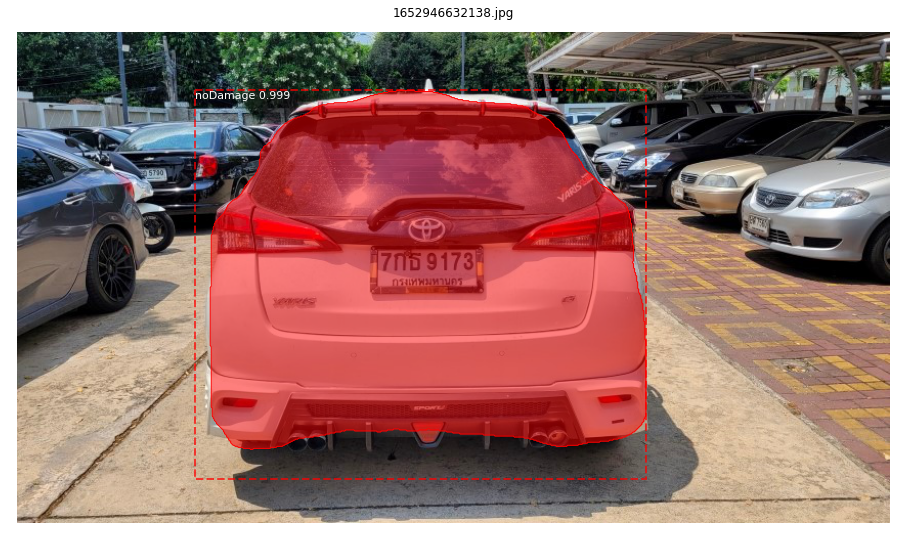

In [ ]:
t = '1652946632138.jpg'


image = skimage.io.imread(os.path.join('/drive/MyDrive/cardamageidentification/dmg_mask_rcnn', t ))
results = model.detect([image], verbose=1)
r = results[0]
print(r['class_ids'])



visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              class_names, r['scores'], title=t )


In [ ]:
test_im_noDmg = fnmatch.filter(os.listdir('/drive/MyDrive/INtern/Project/cardamageidentification/noDmg_testset_v1'),'*.jpeg')
class_names = ['BG','damage','noDamage']

test_list_noDmg = []
result_list_noDmg =[]

for i in test_im_noDmg:
  image = skimage.io.imread(os.path.join('/drive/MyDrive/INtern/Project/cardamageidentification/noDmg_testset_v1', i ))
  results = model.detect([image], verbose=1)
  r = results[0]




  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              class_names, r['scores'], title=i )
  test_list_noDmg.append(i)
  try:    
    result_list_noDmg.append(class_names[r['class_ids'][0]])
  except:
    result_list_noDmg.append('not detect')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd
data = {'img_Name':test_list_noDmg,
        'result':result_list_noDmg
        }
test_df_noDmg = pd.DataFrame(data)

In [ ]:
test_df_noDmg

,img_Name,result
0,isuzu_dmax_65003E00725_022.jpeg,noDamage
1,isuzu_dmax_65003E00725_024.jpeg,noDamage
2,isuzu_dmax_65003E00725_026.jpeg,noDamage
3,isuzu_dmax_65003E00505_025.jpeg,noDamage
4,isuzu_dmax_65003E00505_028.jpeg,noDamage
...,...,...
89,toyota_camry_65003E00749_025.jpeg,noDamage
90,toyota_camry_65003E00702_002.jpeg,noDamage
91,toyota_camry_65003E00702_001.jpeg,noDamage
92,toyota_camry_65003E00702_005.jpeg,noDamage


In [ ]:
damage_noDmg = len(test_df_noDmg[test_df_noDmg.result == 'damage'])
no_damage_noDmg = len(test_df_noDmg[test_df_noDmg.result == 'noDamage'])
not_detect_noDmg = len(test_df_noDmg[test_df_noDmg.result == 'not detect'])
detect_noDmg = len(test_df_noDmg[test_df_noDmg.result != 'not detect'])

In [ ]:
print(f'damage = {damage_noDmg}')
print(f'no_damage = {no_damage_noDmg}')
print(f'not_detect = {not_detect_noDmg}')
print(f'detect = {detect_noDmg}')

damage = 2
no_damage = 87
not_detect = 5
detect = 89


In [ ]:
acc = no_damage_noDmg/detect_noDmg
acc

0.9775280898876404

In [ ]:
no_damage_noDmg/(not_detect_noDmg+detect_noDmg)

0.925531914893617

In [ ]:
(damage+no_damage_noDmg)/(detect+detect_noDmg)

0.936

In [ ]:
(damage+no_damage_noDmg)/(detect+detect_noDmg+not_detect+not_detect_noDmg)

0.7748344370860927